## 코랩 런타임 끊김 방지

In [ ]:
%%html
<audio src="https://henk.tech/colabkobold/silence.m4a" controls>

## 라이브러리

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from scipy.io import wavfile
import torch
from torch.utils.data import Dataset, DataLoader
from skimage.transform import resize
from torchvision import transforms
import torchaudio.transforms as ta_transforms
import math
import torchaudio

## 구글 드라이브에 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/aiffel/AIFFELTHON

PATH = '/content/drive/MyDrive/aiffel/AIFFELTHON/the-circor-digiscope-phonocardiogram-dataset-1.0.3/training_data'
SAMPLE_RATE = 4000
HOP_LENGTH = 40
N_MELS = 128
N_FFT = 1024
WIN_LENGTH = 800

Mounted at /content/drive
/content/drive/MyDrive/aiffel/AIFFELTHON


## 데이터 분석

### 환자 ID를 train, test 데이터로 나눔

In [ ]:
# txt파일 불러오기
file_list = os.listdir(PATH)
txt_list = [os.path.join(PATH, file) for file in file_list if file.endswith(".txt")]

# 환자 아이디를 훈련 데이터셋과 테스트 데이터셋으로 나눔
train_patient_txt, test_patient_txt = train_test_split(txt_list, test_size=0.9, random_state=42)

# 결과 출력
print("Train Patient IDs:", train_patient_txt)
print("Test Patient IDs:", test_patient_txt)

Train Patient IDs: ['/content/drive/MyDrive/aiffel/AIFFELTHON/the-circor-digiscope-phonocardiogram-dataset-1.0.3/training_data/29045.txt', '/content/drive/MyDrive/aiffel/AIFFELTHON/the-circor-digiscope-phonocardiogram-dataset-1.0.3/training_data/50655.txt', '/content/drive/MyDrive/aiffel/AIFFELTHON/the-circor-digiscope-phonocardiogram-dataset-1.0.3/training_data/84734.txt', '/content/drive/MyDrive/aiffel/AIFFELTHON/the-circor-digiscope-phonocardiogram-dataset-1.0.3/training_data/69060.txt', '/content/drive/MyDrive/aiffel/AIFFELTHON/the-circor-digiscope-phonocardiogram-dataset-1.0.3/training_data/50685.txt', '/content/drive/MyDrive/aiffel/AIFFELTHON/the-circor-digiscope-phonocardiogram-dataset-1.0.3/training_data/50109.txt', '/content/drive/MyDrive/aiffel/AIFFELTHON/the-circor-digiscope-phonocardiogram-dataset-1.0.3/training_data/50066.txt', '/content/drive/MyDrive/aiffel/AIFFELTHON/the-circor-digiscope-phonocardiogram-dataset-1.0.3/training_data/85110.txt', '/content/drive/MyDrive/aiff

빠른 테스트를 위해 훈련 데이터의 10%만 가져옵니다

In [ ]:
file_list = os.listdir(PATH)
patient_list = [os.path.join(PATH,file) for file in file_list if file.endswith(".txt")]

#------------------확인용-------------
wav_list = [os.path.join(PATH,file) for file in file_list if file.endswith(".wav")]
label_list = [os.path.join(PATH,file) for file in file_list if file.endswith(".tsv")]
head_list = [os.path.join(PATH,file) for file in file_list if file.endswith(".hea")]

In [ ]:
heas = []
wavs = []
tsvs = []

In [ ]:
# for path_txt in patient_list:
for path_txt in txt_list:
    #print("{0}.hea".format(path_txt[:-4]))
    with open("{0}.txt".format(path_txt[:-4]), "r") as f:
        P_id, n, sr = f.readline().split()
        for _ in range(int(n)):
            #print(f.readline())
            _, hea, wav, tsv = f.readline().split()
            heas.append(hea)
            wavs.append(wav)
            tsvs.append(tsv)

In [ ]:
# 음성 길이 확인
hea_list=[]
for hea in heas:
    path_hea = os.path.join(PATH,hea)
    with open(path_hea, "r") as f:
        id, _, sr, length = f.readline().split()
        hea_list.append(int(length)/float(sr))

평균 :  22.87030121719886
최대값 :  64.512
최소값 :  5.152
----
25
2545


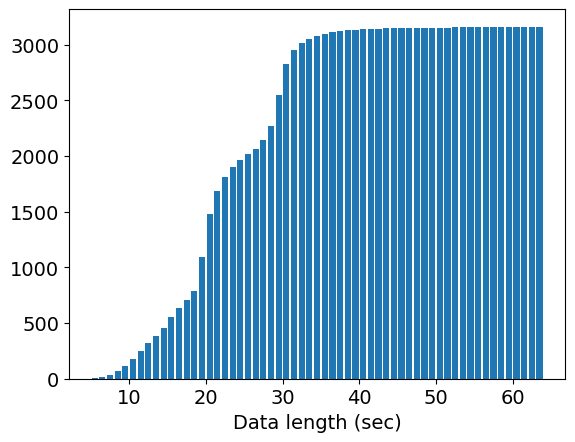

In [ ]:
hea_list = np.array(hea_list) ## 데이터
bins = np.arange(5,65,1)

print("평균 : ", np.average(hea_list))
print("최대값 : ", np.max(hea_list))
print("최소값 : ", np.min(hea_list))

cut = pd.cut(hea_list, bins=bins) ## 데이터를 일정 구간으로 n등분한다.
#print(cut.describe())

plt.hist(hea_list, bins, rwidth = 0.8, cumulative=True)
plt.xlabel('Data length (sec)', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
print("----")
hist, _ =np.histogram(hea_list, bins=bins)
end_index = np.searchsorted(bins, 29, side='right')
print(end_index)

count = np.sum(hist[0:25])
print(count)#5~28초 사이의 데이터 개수

In [ ]:
s1_ranges = []
s2_ranges = []
for tsv in tsvs:
    path_tsv = os.path.join(PATH,tsv)
    with open(path_tsv, "r") as f:
        while 1:
            line = f.readline()
            if not line: break
            start, end, s_type = line.split()
            if s_type == "1":
                s1_ranges.append(float(end)-float(start))

            elif  s_type == "3":
                s2_ranges.append(float(end)-float(start))

In [ ]:
s1_ranges = np.array(s1_ranges) ## 데이터
s2_ranges = np.array(s2_ranges)

bins = np.arange(5,65,1)

print("s1 길이 최소값 : ", np.min(s1_ranges))
print("s1 길이 최대값 : ", np.max(s1_ranges))
print("s1 길이 평균 : ", np.average(s1_ranges))
print("---------------------")
print("s2 길이 최소값 : ", np.min(s2_ranges))
print("s2 길이 최대값 : ", np.max(s2_ranges))
print("s2 길이 평균 : ", np.average(s2_ranges))

s1 길이 최소값 :  0.008209000000000799
s1 길이 최대값 :  0.7291699999999999
s1 길이 평균 :  0.119164496582365
---------------------
s2 길이 최소값 :  0.0008700000000008146
s2 길이 최대값 :  0.6797499999999985
s2 길이 평균 :  0.10533918449571068


## 데이터 변환
## wav => (전체 파일 개수, 주파수, 시간)
## tsv => (class, x1, x2)

In [ ]:
class Biquad:

  # pretend enumeration
  LOWPASS, HIGHPASS, BANDPASS, PEAK, NOTCH, LOWSHELF, HIGHSHELF = range(7)

  def __init__(self, typ, freq, srate, Q, dbGain=0):
    types = {
      Biquad.LOWPASS : Biquad.lowpass,
      Biquad.HIGHPASS : Biquad.highpass,
      Biquad.BANDPASS : Biquad.bandpass,
      Biquad.PEAK : Biquad.peak,
      Biquad.NOTCH : Biquad.notch,
      Biquad.LOWSHELF : Biquad.lowshelf,
      Biquad.HIGHSHELF : Biquad.highshelf
    }
    assert typ in types
    self.typ = typ
    self.freq = float(freq)
    self.srate = float(srate)
    self.Q = float(Q)
    self.dbGain = float(dbGain)
    self.a0 = self.a1 = self.a2 = 0
    self.b0 = self.b1 = self.b2 = 0
    self.x1 = self.x2 = 0
    self.y1 = self.y2 = 0
    # only used for peaking and shelving filter types
    A = math.pow(10, dbGain / 40)
    omega = 2 * math.pi * self.freq / self.srate
    sn = math.sin(omega)
    cs = math.cos(omega)
    alpha = sn / (2*Q)
    beta = math.sqrt(A + A)
    types[typ](self,A, omega, sn, cs, alpha, beta)
    # prescale constants
    self.b0 /= self.a0
    self.b1 /= self.a0
    self.b2 /= self.a0
    self.a1 /= self.a0
    self.a2 /= self.a0

  def lowpass(self,A, omega, sn, cs, alpha, beta):
    self.b0 = (1 - cs) /2
    self.b1 = 1 - cs
    self.b2 = (1 - cs) /2
    self.a0 = 1 + alpha
    self.a1 = -2 * cs
    self.a2 = 1 - alpha

  def highpass(self, A, omega, sn, cs, alpha, beta):
    self.b0 = (1 + cs) /2
    self.b1 = -(1 + cs)
    self.b2 = (1 + cs) /2
    self.a0 = 1 + alpha
    self.a1 = -2 * cs
    self.a2 = 1 - alpha

  def bandpass(self, A, omega, sn, cs, alpha, beta):
    self.b0 = alpha
    self.b1 = 0
    self.b2 = -alpha
    self.a0 = 1 + alpha
    self.a1 = -2 * cs
    self.a2 = 1 - alpha

  def notch(self, A, omega, sn, cs, alpha, beta):
    self.b0 = 1
    self.b1 = -2 * cs
    self.b2 = 1
    self.a0 = 1 + alpha
    self.a1 = -2 * cs
    self.a2 = 1 - alpha

  def peak(self, A, omega, sn, cs, alpha, beta):
    self.b0 = 1 + (alpha * A)
    self.b1 = -2 * cs
    self.b2 = 1 - (alpha * A)
    self.a0 = 1 + (alpha /A)
    self.a1 = -2 * cs
    self.a2 = 1 - (alpha /A)

  def lowshelf(self, A, omega, sn, cs, alpha, beta):
    self.b0 = A * ((A + 1) - (A - 1) * cs + beta * sn)
    self.b1 = 2 * A * ((A - 1) - (A + 1) * cs)
    self.b2 = A * ((A + 1) - (A - 1) * cs - beta * sn)
    self.a0 = (A + 1) + (A - 1) * cs + beta * sn
    self.a1 = -2 * ((A - 1) + (A + 1) * cs)
    self.a2 = (A + 1) + (A - 1) * cs - beta * sn

  def highshelf(self, A, omega, sn, cs, alpha, beta):
    self.b0 = A * ((A + 1) + (A - 1) * cs + beta * sn)
    self.b1 = -2 * A * ((A - 1) + (A + 1) * cs)
    self.b2 = A * ((A + 1) + (A - 1) * cs - beta * sn)
    self.a0 = (A + 1) - (A - 1) * cs + beta * sn
    self.a1 = 2 * ((A - 1) - (A + 1) * cs)
    self.a2 = (A + 1) - (A - 1) * cs - beta * sn

  # perform filtering function
  def __call__(self, x):
    y = self.b0 * x + self.b1 * self.x1 + self.b2 * self.x2 - self.a1 * self.y1 - self.a2 * self.y2
    self.x2 = self.x1
    self.x1 = x
    self.y2 = self.y1
    self.y1 = y
    return y

  # provide a static result for a given frequency f
  def result(self, f):
    phi = (math.sin(math.pi * f * 2/(2*self.srate)))**2
    r =((self.b0+self.b1+self.b2)**2 - \
    4*(self.b0*self.b1 + 4*self.b0*self.b2 + \
    self.b1*self.b2)*phi + 16*self.b0*self.b2*phi*phi) / \
    ((1+self.a1+self.a2)**2 - 4*(self.a1 + 4*self.a2 + \
    self.a1*self.a2)*phi + 16*self.a2*phi*phi)
    if(r < 0):
      r = 0
    return r**(.5)

  # provide a static log result for a given frequency f
  def log_result(self, f):
    try:
      r = 20 * math.log10(self.result(f))
    except:
      r = -200
    return r

  # return computed constants
  def constants(self):
    return self.a1, self.a2, self.b0, self.b1, self.b2

  def __str__(self):
    return "Type:%d,Freq:%.1f,Rate:%.1f,Q:%.1f,Gain:%.1f" % (self.typ,self.freq,self.srate,self.Q,self.dbGain)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, path, txt_list,
                 filtering=False,
                 filter_params=(Biquad.LOWPASS, 125, SAMPLE_RATE, 0.707),
                 clipping=False,
                 target_size=(300, 300),
                 th=5,
                 resizing=False):
        self.path = path
        self.txt_list = txt_list

        self.filtering = filtering
        self.filter_params = filter_params
        self.clipping = clipping
        self.target_size = target_size
        self.th = int(th * SAMPLE_RATE / HOP_LENGTH)
        self.resizing = resizing

        self.get_file_list()

        self.delete_list = []
        self.x = self.get_mel_spectrogram()
        self.y = self.get_label()
        self.delete_data()

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def get_file_list(self):
        self.heas = []
        self.wavs = []
        self.tsvs = []

        for path_txt in self.txt_list:
            with open(path_txt, "r") as f:
                P_id, n, sr = f.readline().split()
                for _ in range(int(n)):
                    _, hea, wav, tsv = f.readline().split()
                    self.heas.append(hea)
                    self.wavs.append(wav)
                    self.tsvs.append(tsv)
        self.heas.sort()
        self.wavs.sort()
        self.tsvs.sort()

    # torchaudio로 필터링 적용
    def apply_filter_torchaudio(self, audio, params):
        biquad_filter = Biquad(*params)
        a1, a2, b0, b1, b2 = biquad_filter.constants()
        filtered_audio = torchaudio.functional.biquad(
            waveform=audio,
            b0=b0,
            b1=b1,
            b2=b2,
            a0=1.0,
            a1=a1,
            a2=a2
        )
        return filtered_audio

    def blank_clipping(self, img):
        img[img < 10/255] = 0
        for row in range(img.shape[0] - 1, 0, -1):
            black_percent = len(np.where(img[row,:]==0)[0])/len(img[row,:])
            if black_percent < 0.80:
                break
        if (row - 1) > 0:
            img = img[:(row - 1), :]
        return img

    def padding(self, spec, target_length, padding_value=0):
        pad_width = target_length - spec.shape[-1]
        padded_spec = torch.nn.functional.pad(spec, (0, pad_width, 0, 0), "constant", 0)
        return padded_spec

    def resize_spectrogram(self, spec, new_shape):
        resized_spec = transforms.functional.resize(img=spec, size=new_shape, antialias=None)
        return resized_spec

    def normalize_spectrogram(self, spec):
        normalized = (spec-spec.min()) / (spec.max() - spec.min())
        return normalized

    def get_mel_spectrogram(self):
        audio_list = []
        self.scale_list = []
        self.iter_list = []

        for path_wav in self.wavs:
            path = os.path.join(PATH, path_wav)
            # Torchaudio 이용하여 파일 로드
            x = torchaudio.load(path)[0]
            # Filtering
            if self.filtering is True:
                x = self.apply_filter_torchaudio(x, self.filter_params) # 수정된 필터링

            # 멜스펙트로그램 변환
            ms = librosa.feature.melspectrogram(y=np.array(x[0]),
                                               sr=SAMPLE_RATE,
                                               n_mels=N_MELS,
                                               n_fft=N_FFT,
                                               hop_length=HOP_LENGTH,
                                               win_length=WIN_LENGTH)
            ms = librosa.power_to_db(ms, ref=np.max)

            # 0~1로 정규화
            ms = self.normalize_spectrogram(ms)

            # Blank region clipping
            if self.clipping is True:
                ms = self.blank_clipping(ms)

            ms = torch.from_numpy(ms)
            ms = ms.unsqueeze(0)

            # 원본 wav의 길이가 th보다 길다면 Slicing
            if ms.shape[-1] > self.th + 1:
                scale = 1
                num_splits = ms.shape[-1] // self.th    # wav길이 == th의 배수
                if ms.shape[-1] % self.th != 0: # wav길이 != th의 배수
                    num_splits += 1
                self.iter_list.append(num_splits)

                for i in range(num_splits):
                    start_idx = i * self.th
                    end_idx = (i + 1) * self.th + 1
                    split = ms[..., start_idx:end_idx]

                    # th보다 길이가 짧다면
                    if split.shape[-1] < self.th + 1:
                        # Resizing
                        if self.resizing is True:
                            scale = (self.th + 1) / split.shape[-1]
                            target_shape = (split.shape[-2], self.th + 1)
                            split = self.resize_spectrogram(split, target_shape)
                        # Padding
                        else:
                            split = self.padding(split, self.th + 1)
                    # 최종 Resizing
                    resized = self.resize_spectrogram(split, self.target_size)
                    audio_list.append(resized)
                    if self.resizing is True:
                        self.scale_list.append(scale)

            # 원본 wav의 길이가 th보다 짧거나 같다면
            else:
                self.iter_list.append(1)
                scale = 1
                # th보다 짧다면
                if ms.shape[-1] < self.th + 1:
                    # Resizing
                    if self.resizing is True:
                        scale = (self.th + 1) / ms.shape[-1]
                        target_shape = (ms.shape[-2], self.th + 1)
                        ms = self.resize_spectrogram(ms, target_shape)
                    # Padding
                    else:
                        ms = self.padding(ms, self.th + 1)
                # 최종 resizing
                ms = self.resize_spectrogram(ms, self.target_size)
                audio_list.append(ms)
                if self.resizing is True:
                    self.scale_list.append(scale)
        return torch.stack(audio_list)

    def get_label(self):
        labels = []
        idx = 0
        for i, path_tsv in enumerate(self.tsvs):
            path = os.path.join(PATH, path_tsv)
            tsv_data = pd.read_csv(path, sep='\t', header=None)
            iter = self.iter_list[i]
            continuous = False
            next_end = 0
            next_class = 0
            for _iter in range(iter):
                label = []
                if self.resizing is True:
                    scale = self.scale_list[sum(self.iter_list[:i]) + _iter]
                for _, tsv_row in tsv_data.iterrows():
                    # 이전 구간에서 이어진다면 tsv_row[0] = 0
                    if continuous is True:
                        tsv_row[0] = 0
                        tsv_row[1] = next_end
                        tsv_row[2] = next_class
                        continuous = False

                    # 이전 구간에서 이어지지 않는다면 새로 데이터 가져오기
                    elif tsv_row[2] in [1, 3]:
                        # 구간 불러와서 sr값 곱하고 hop_legth로 나누기
                        tsv_row[0] = tsv_row[0] * SAMPLE_RATE / HOP_LENGTH - (_iter * self.th)
                        tsv_row[1] = tsv_row[1] * SAMPLE_RATE / HOP_LENGTH - (_iter * self.th)
                        tsv_row[2] = 1 if tsv_row[2] == 1 else 2    # S1=1, S2=2
                        # 시작점이 th 이상이라면, 이전 구간 이미지의 라벨이라면 continue
                        if tsv_row[0] >= self.th or tsv_row[0] < 0:
                            continue

                        # th보다 길이가 길다면 Slicing
                        elif tsv_row[1] > self.th:
                            next_end = tsv_row[1] - self.th
                            next_class = tsv_row[2]
                            tsv_row[1] = self.th
                            continuous = True
                            # 최종 resize한 값 으로 보간
                            tsv_row[0] *= (self.target_size[1] - 1) / self.th
                            tsv_row[1] *= (self.target_size[1] - 1) / self.th
                            label.append([tsv_row[0] / self.target_size[1], 0 / self.target_size[0],
                                  tsv_row[1] / self.target_size[1], self.target_size[0] / self.target_size[0],
                                  int(tsv_row[2])])# xmin, ymin, xmax, ymax, cls
                            break

                    # 이전 값에서 이어지지 않으면서 S1, S2가 아닌 경우 continue
                    else: continue

                    # resize를 하였다면 라벨 값도 스케일링
                    if self.resizing is True:
                        tsv_row[0] *= scale
                        tsv_row[1] *= scale

                    # 최종 resize한 값 으로 보간
                    tsv_row[0] *= (self.target_size[1] - 1) / self.th
                    tsv_row[1] *= (self.target_size[1] - 1) / self.th
                    label.append([tsv_row[0] / self.target_size[1], 0 / self.target_size[0],
                                  tsv_row[1] / self.target_size[1], self.target_size[0] / self.target_size[0],
                                  int(tsv_row[2])])# xmin, ymin, xmax, ymax, cls
                if(len(label)==0):
                    self.delete_list.append(idx)
                idx += 1
                labels.append(label)
        return labels

    def delete_data(self):
        delete_count=0
        for i in self.delete_list:
            del self.y[i-delete_count]
            delete_count+=1
        self.x = self.x[[i for i in range(self.x.size(0)) if i not in self.delete_list]]

※주의사항: colab 기준 tran_patient_txt를 th 5초, target_size (300, 300)으로 설정했을 시 RAM을 10GB가까이 사용합니다!

아래는 전체 데이터의 10%만을 불러와 설정한 데이터셋입니다.

In [ ]:
# 필터의 종류, 125Hz를 중간 주파수로 지정(심음 : 0~250Hz)
# 필터 타입, 주파수, 샘플레이트, Q
filters = [
    ('lowpass', 'biquad', (Biquad.LOWPASS, 125, SAMPLE_RATE, 1.0)),
    ('highpass', 'biquad', (Biquad.HIGHPASS, 125, SAMPLE_RATE, 1.0)),
    ('bandpass', 'biquad', (Biquad.BANDPASS, 125, SAMPLE_RATE, 1.0)),
    ('notch', 'biquad', (Biquad.NOTCH, 125, SAMPLE_RATE, 1.0)),
    ('peak', 'biquad', (Biquad.PEAK, 125, SAMPLE_RATE, 1.0, 1.0)),
    ('lowshelf', 'biquad', (Biquad.LOWSHELF, 125, SAMPLE_RATE, 1.0, 1.0)),
    ('highshelf', 'biquad', (Biquad.HIGHSHELF, 125, SAMPLE_RATE, 1.0, 1.0))
]

In [ ]:
dataset = CustomDataset(PATH, train_patient_txt, filtering=True, filter_params=filters[0][2], clipping=True, resizing=True)

In [ ]:
len(dataset.delete_list)
dataset.delete_list
print(len(dataset.y),len(dataset.x))
dataset.x.size(0)

1011 1011


1011

### 데이터, 라벨 변환 결과 이미지로 시각화

In [ ]:
for i, d in enumerate(dataset):
    if i == 20:
        break
    x, y = d
    # print(x[0].shape)

    plt.figure(figsize=(10,8))
    # 스펙트로그램 시각화
    librosa.display.specshow(
        librosa.power_to_db(np.array(x[0]), ref=np.max), sr=SAMPLE_RATE, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel', cmap='magma')

    # 레이블 시각화
    for label in y:
        start, _, end, _, class_id= label
        start /= SAMPLE_RATE / HOP_LENGTH / 300
        end /= SAMPLE_RATE / HOP_LENGTH / 300
        color = 'red' if class_id == 1 else 'blue'
        plt.axvspan(start, end, color=color)

    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Spectrogram{i + 1} (dB)")

Output hidden; open in https://colab.research.google.com to view.